$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Example 1 and 2 from [Fuchs et al. (2022)](https://arxiv.org/abs/2203.06095)

In [1]:
%matplotlib notebook
from openquantumcomputing.QAOABase import QAOABase
from openquantumcomputing.mixer_utilities import *
from qiskit import *
from matplotlib import pyplot as plt
import time
import itertools

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [3]:
def plot_hist(qaoa, angles, params = {}):
    fig = plt.figure(figsize = (9.5, 5))
    hist = qaoa.hist(
        angles = angles, backend = qasmSim, shots = 10000, params = params)
    plt.bar(range(len(hist)), 
            np.array(list(hist.values())) / 10000., 
            tick_label = [key[::-1] for key in list(hist.keys())])
    plt.xlabel("state"); plt.ylabel("probability"); plt.xticks(rotation=85)
    fig.show()

In [4]:
qasmSim = Aer.get_backend("qasm_simulator") 

## Example 1

### hard-coded circuit 

Feasible subspace: $ B = \{\ket{100}, \ket{010}, \ket{011}\} $

$$H_{mixer} = \frac{1}{2}(XXI + XXZ + IIX + ZIX + XXX - XYY)$$

$$ H_{cost} \ket{\psi} = 1, \forall \psi \in B $$
$$ H_{cost} \ket{\psi} = 20, \forall \psi \notin B $$

In [5]:
feasible_states = np.array(["100", "010", "011"])

# decompose H_cost into pauli string
H_cost = 20. * np.ones(2 ** 3)
for feasible_state in feasible_states:
    H_cost[int(feasible_state, 2)] = 1.
H_cost = Symbol("c") * matrix_to_sympy(np.diag(H_cost))
display(H_cost)

dim= 3.0


c*(12.875*1x1x1 - 2.375*1x1xsigma3 + 2.375*1xsigma3x1 - 2.375*1xsigma3xsigma3 - 2.375*sigma3x1x1 + 2.375*sigma3x1xsigma3 + 7.125*sigma3xsigma3x1 + 2.375*sigma3xsigma3xsigma3)

In [6]:
class QAOA_example1_hard_coded(QAOABase):
    def cost(self, string, params):
        if string in ["100", "010", "011"]:
            return 1.
        return 20.

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, [q[2], q[1], q[0]])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # cost hamiltonian
            # -IIZ
            circ.rz(-2. * gamma * -19. / 8., q[2])
            circ.barrier()
            
            # IZI
            circ.rz(-2. * gamma * 19. / 8., q[1])
            circ.barrier()
            
            # -IZZ
            circ.cx(q[1], q[2])
            circ.rz(-2. * gamma * -19. / 8., q[2])
            circ.cx(q[1], q[2])
            circ.barrier()
   
            # -ZII
            circ.rz(-2. * gamma * -19. / 8., q[0])
            circ.barrier()
        
            # ZIZ
            circ.cx(q[0], q[2])
            circ.rz(-2. * gamma * 19. / 8., q[2])
            circ.cx(q[0], q[2])
            circ.barrier()
            
            # ZZI
            circ.cx(q[0], q[1])
            circ.rz(-2. * gamma * 57. / 8., q[1])
            circ.cx(q[0], q[1])
            circ.barrier()
            
            # ZZZ
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * gamma * 19. / 8., q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.barrier()
        
            # mixer hamiltonian
            # XXI
            circ.h([q[0], q[1]])
            circ.cx(q[0], q[1])
            circ.rz(-2. * beta * 0.5, q[1])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1]])
            circ.barrier()
            
            # XXZ
            circ.h([q[0], q[1]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1]])
            circ.barrier()

            # IIX
            circ.h(q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.h(q[2])
            circ.barrier()

            # ZIX
            circ.h(q[2])
            circ.cx(q[0], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[0], q[2])
            circ.h(q[2])
            circ.barrier()
            
            # XXX
            circ.h([q[0], q[1], q[2]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * 0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1], q[2]])
            circ.barrier()
            
            # -XYY
            circ.s([q[1], q[2]])
            circ.h([q[0], q[1], q[2]])
            circ.cx(q[0], q[1])
            circ.cx(q[1], q[2])
            circ.rz(-2. * beta * -0.5, q[2])
            circ.cx(q[1], q[2])
            circ.cx(q[0], q[1])
            circ.h([q[0], q[1], q[2]])
            circ.sdg([q[1], q[2]])
            circ.barrier()
        
        circ.measure(q, c)
        return circ

display(QAOA_example1_hard_coded().createCircuit([1.0, 1.0], 1).draw())

┌────────────────────────────────────────────────┐ ░              ░ »
q0_0: ┤2                                               ├─░──────────────░─»
      │                                                │ ░              ░ »
q0_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░──────────────░─»
      │                                                │ ░ ┌──────────┐ ░ »
q0_2: ┤0                                               ├─░─┤ Rz(4.75) ├─░─»
      └────────────────────────────────────────────────┘ ░ └──────────┘ ░ »
c0: 3/════════════════════════════════════════════════════════════════════»
                                                                          »
«                    ░                        ░ ┌──────────┐ ░      »
«q0_0: ──────────────░────────────────────────░─┤ Rz(4.75) ├─░───■──»
«      ┌───────────┐ ░                        ░ └──────────┘ ░   │  »
«q0_1: ┤ Rz(-4.75) ├─░───■────────────────■───░──────────────░───┼──»
«      └───────────┘ ░ ┌─┴─┐┌──────────┐┌─┴─┐ ░              ░ ┌─┴─┐»
«q0_2: ──────────────░─┤ X ├┤ Rz(4.75) ├┤ X ├─░──────────────░─┤ X ├»
«                    ░ └───┘└──────────┘└───┘ ░              ░ └───┘»
«c0: 3/═════════════════════════════════════════════════════════════»
«                                                                   »
«                         ░                          ░                        »
«q0_0: ───────────────■───░───■──────────────────■───░───■────────────────────»
«                     │   ░ ┌─┴─┐┌────────────┐┌─┴─┐ ░ ┌─┴─┐                  »
«q0_1: ───────────────┼───░─┤ X ├┤ Rz(-14.25) ├┤ X ├─░─┤ X ├──■───────────────»
«      ┌───────────┐┌─┴─┐ ░ └───┘└────────────┘└───┘ ░ └───┘┌─┴─┐┌───────────┐»
«q0_2: ┤ Rz(-4.75) ├┤ X ├─░──────────────────────────░──────┤ X ├┤ Rz(-4.75) ├»
«      └───────────┘└───┘ ░                          ░      └───┘└───────────┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                 ░ ┌───┐                    ┌───┐ ░ ┌───┐                    »
«q0_0: ───────■───░─┤ H ├──■──────────────■──┤ H ├─░─┤ H ├──■─────────────────»
«           ┌─┴─┐ ░ ├───┤┌─┴─┐┌────────┐┌─┴─┐├───┤ ░ ├───┤┌─┴─┐               »
«q0_1: ──■──┤ X ├─░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├─░─┤ H ├┤ X ├──■────────────»
«      ┌─┴─┐└───┘ ░ └───┘└───┘└────────┘└───┘└───┘ ░ └───┘└───┘┌─┴─┐┌────────┐»
«q0_2: ┤ X ├──────░────────────────────────────────░───────────┤ X ├┤ Rz(-1) ├»
«      └───┘      ░                                ░           └───┘└────────┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                ┌───┐ ░                      ░                               »
«q0_0: ───────■──┤ H ├─░──────────────────────░────────■──────────────■───────»
«           ┌─┴─┐├───┤ ░                      ░        │              │       »
«q0_1: ──■──┤ X ├┤ H ├─░──────────────────────░────────┼──────────────┼───────»
«      ┌─┴─┐└───┘└───┘ ░ ┌───┐┌────────┐┌───┐ ░ ┌───┐┌─┴─┐┌────────┐┌─┴─┐┌───┐»
«q0_2: ┤ X ├───────────░─┤ H ├┤ Rz(-1) ├┤ H ├─░─┤ H ├┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├»
«      └───┘           ░ └───┘└────────┘└───┘ ░ └───┘└───┘└────────┘└───┘└───┘»
«c0: 3/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«       ░ ┌───┐                              ┌───┐ ░ ┌───┐               »
«q0_0: ─░─┤ H ├──■────────────────────────■──┤ H ├─░─┤ H ├───────■───────»
«       ░ ├───┤┌─┴─┐                    ┌─┴─┐├───┤ ░ ├───┤┌───┐┌─┴─┐     »
«q0_1: ─░─┤ H ├┤ X ├──■──────────────■──┤ X ├┤ H ├─░─┤ S ├┤ H ├┤ X ├──■──»
«       ░ ├───┤└───┘┌─┴─┐┌────────┐┌─┴─┐├───┤└───┘ ░ ├───┤├───┤└───┘┌─┴─┐»
«q0_2: ─░─┤ H ├─────┤ X ├┤ Rz(-1) ├┤ X ├┤ H ├──────░─┤ S ├┤ H ├─────┤ X ├»
«       ░ └───┘     └───┘└────────┘└───┘└───┘      ░ └───┘└───┘     └───┘»
«c0: 3/

In [7]:
qaoa_example1_hard_coded = QAOA_example1_hard_coded()
qaoa_example1_hard_coded.increase_depth(backend = qasmSim, precision = 0.25)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0


<IPython.core.display.Javascript object>


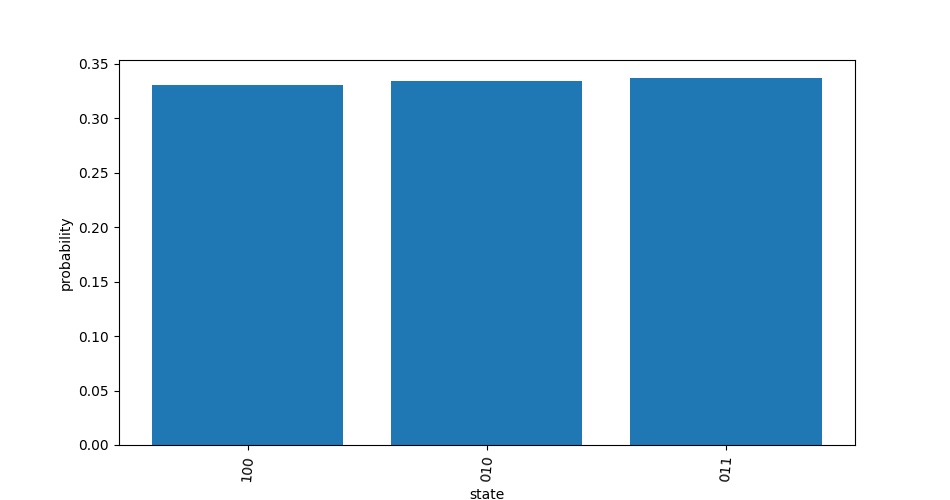

In [8]:
plot_hist(qaoa_example1_hard_coded, qaoa_example1_hard_coded.angles_hist["d1_final"])

### Circuit from algorithms

In [9]:
# create mixer from algorithm 3
table = {
    (0, 1) : np.array(["000", "110"]),
    (1, 2) : np.array(["000", "001"]),
    (2, 0) : np.array(["000", "111"])}

H_mixer = 0
T_c = get_T(2, "nearest_int")
for index, ((i, j), mix_states) in enumerate(table.items()):
    T_ij = get_T(3, "leftright", i = i, j = j)
    H_b_ij = get_Pauli_string_with_algorithm3(feasible_states, T_ij)
    H_c_ij = get_Pauli_string_with_algorithm3(mix_states, T_c)
    c = Symbol(f"c{index}", commutative = False)
    H_mixer += c * simplifyH(H_b_ij + H_c_ij)
display(H_mixer)

c0*(0.5*sigma1xsigma1x1 + 0.5*sigma1xsigma1xsigma3) + c1*(0.5*1x1xsigma1 + 0.5*sigma3x1xsigma1) + c2*(0.5*sigma1xsigma1xsigma1 - 0.5*sigma1xsigma2xsigma2)

In [10]:
cost_circuit_array = Circuit_maker(H_cost)
mixer_circuit_array = Circuit_maker(H_mixer)
params1 = {"cost_circuit_array" : cost_circuit_array,
           "mixer_circuit_array" : mixer_circuit_array}

In [11]:
class QAOA_example1_with_algorithms(QAOABase):
    def cost(self, string, params):
        if string in ["100", "010", "011"]:
            return 1.
        return 20.

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        cost_circuit_array = params.get("cost_circuit_array")
        mixer_circuit_array = params.get("mixer_circuit_array")
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, q[::-1])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            cost_circuit_array.add_gates(circ, beta)

            
        circ.measure(q, c)
        return circ

display(QAOA_example1_with_algorithms().createCircuit(
    [1.0, 1.0], 1, params = params1).draw())

┌────────────────────────────────────────────────┐ ░              »
q11419_0: ┤2                                               ├─░──────────────»
          │                                                │ ░ ┌───────────┐»
q11419_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░─┤ Rz(-4.75) ├»
          │                                                │ ░ └───────────┘»
q11419_2: ┤0                                               ├─░──────────────»
          └────────────────────────────────────────────────┘ ░              »
  c415: 3/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«q11419_0: ──■─────────────────■────■──────────────────────────────■────────■──»
«            │                 │  ┌─┴─┐                          ┌─┴─┐    ┌─┴─┐»
«q11419_1: ──┼─────────────────┼──┤ X ├──■─────────────────■─────┤ X ├────┤ X ├»
«          ┌─┴─┐┌───────────┐┌─┴─┐└───┘┌─┴─┐┌───────────┐┌─┴─┐┌──┴───┴───┐└───┘»
«q11419_2: ┤ X ├┤ Rz(-4.75) ├┤ X ├─────┤ X ├┤ Rz(-4.75) ├┤ X ├┤ Rz(4.75) ├─────»
«          └───┘└───────────┘└───┘     └───┘└───────────┘└───┘└──────────┘     »
«  c415: 3/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                             ┌──────────┐                                   »
«q11419_0: ────────────────■──┤ Rz(4.75) ├────────────────────────────────■──»
«          ┌────────────┐┌─┴─┐└──────────┘                 ┌───────────┐  │  »
«q11419_1: ┤ Rz(-14.25) ├┤ X ├─────■────────────────────■──┤ Rz(-4.75) ├──┼──»
«          └────────────┘└───┘   ┌─┴─┐    ┌──────────┐┌─┴─┐└───────────┘┌─┴─┐»
«q11419_2: ──────────────────────┤ X ├────┤ Rz(4.75) ├┤ X ├─────────────┤ X ├»
«                                └───┘    └──────────┘└───┘             └───┘»
«  c415: 3/══════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                                         »
«q11419_0: ───────────────■────■──────────────────────────────■────────■──»
«                         │  ┌─┴─┐                          ┌─┴─┐    ┌─┴─┐»
«q11419_1: ───────────────┼──┤ X ├──■─────────────────■─────┤ X ├────┤ X ├»
«          ┌───────────┐┌─┴─┐└───┘┌─┴─┐┌───────────┐┌─┴─┐┌──┴───┴───┐└───┘»
«q11419_2: ┤ Rz(-4.75) ├┤ X ├─────┤ X ├┤ Rz(-4.75) ├┤ X ├┤ Rz(4.75) ├─────»
«          └───────────┘└───┘     └───┘└───────────┘└───┘└──────────┘     »
«  c415: 3/═══════════════════════════════════════════════════════════════»
«                                                                         »
«                             ┌──────────┐            ┌─┐           
«q11419_0: ────────────────■──┤ Rz(4.75) ├────────────┤M├───────────
«          ┌────────────┐┌─┴─┐└──────────┘            └╥┘     ┌─┐   
«q11419_1: ┤ Rz(-14.25) ├┤ X ├─────■───────────────────╫───■──┤M├───
«          └────────────┘└───┘   ┌─┴─┐    ┌──────────┐ ║ ┌─┴─┐└╥┘┌─┐
«q11419_2: ──────────────────────┤ X ├────┤ Rz(4.75) ├─╫─┤ X ├─╫─┤M├
«                                └───┘    └──────────┘ ║ └───┘ ║ └╥┘
«  c415: 3/════════════════════════════════════════════╩═══════╩══╩═
«                                                      0       1  2

In [12]:
qaoa_example1_with_algorithms = QAOA_example1_with_algorithms()
qaoa_example1_with_algorithms.increase_depth(backend = qasmSim, precision = 0.25, params = params1)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0


<IPython.core.display.Javascript object>


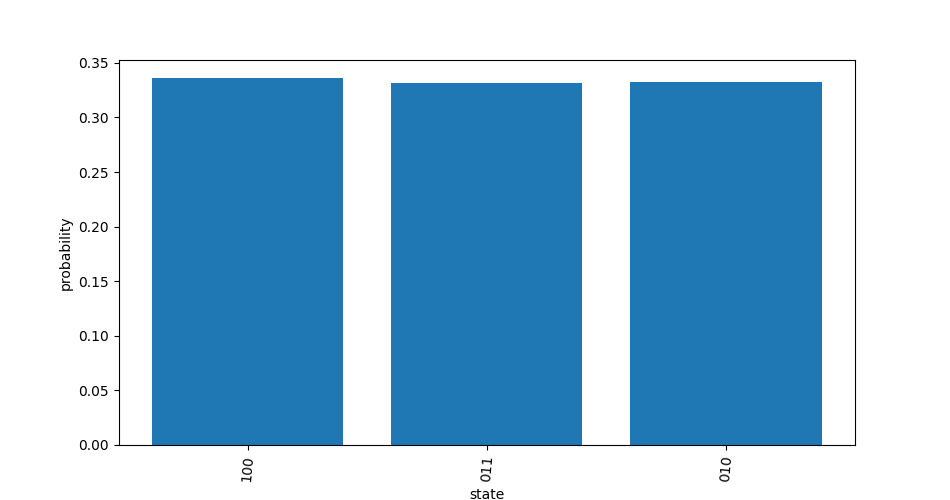

In [13]:
plot_hist(qaoa_example1_with_algorithms, qaoa_example1_with_algorithms.angles_hist["d1_final"], params = params1)

### Interesting cost function with algorithms

In [14]:
H_cost_interesting = np.array([5.0, 2.0, 2.0, 2.5, 2.0, 1.0, 3.0, 0.1])
H_cost_interesting_sympy = Symbol("c") * matrix_to_sympy(np.diag(H_cost_interesting))

display(H_cost_interesting)
display(H_cost_interesting_sympy)

dim= 3.0


array([5. , 2. , 2. , 2.5, 2. , 1. , 3. , 0.1])

c*(2.2*1x1x1 + 0.8*1x1xsigma3 + 0.3*1xsigma3x1 + 0.2*1xsigma3xsigma3 + 0.675*sigma3x1x1 - 0.175*sigma3x1xsigma3 + 0.325*sigma3xsigma3x1 + 0.675*sigma3xsigma3xsigma3)

In [15]:
interesting_cost_circuit_array = Circuit_maker(H_cost_interesting_sympy)

params3 = {"cost_circuit_array" : interesting_cost_circuit_array,
           "mixer_circuit_array" : mixer_circuit_array,
           "H_cost" : H_cost_interesting}

In [16]:
class QAOA_example1_interesting(QAOABase):
    def cost(self, string, params):
        H_cost = params.get("H_cost")
        return H_cost[int(string, 2)]
    
    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        cost_circuit_array = params.get("cost_circuit_array")
        mixer_circuit_array = params.get("mixer_circuit_array")
        
        # initial state
        ampl = 1. / np.sqrt(3.)
        ampl_vec = [0., 0., ampl, ampl, ampl, 0., 0., 0.]
        circ.initialize(ampl_vec, q[::-1])
        circ.barrier()
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            cost_circuit_array.add_gates(circ, beta)
            
        circ.measure(q, c)
        return circ

display(QAOA_example1_interesting().createCircuit(
    [1.0, 1.0], 1, params = params3).draw())

┌────────────────────────────────────────────────┐ ░ ┌───────────┐»
q18854_0: ┤2                                               ├─░─┤ Rz(-1.35) ├»
          │                                                │ ░ └───────────┘»
q18854_1: ┤1 Initialize(0,0,0.57735,0.57735,0.57735,0,0,0) ├─░──────────────»
          │                                                │ ░              »
q18854_2: ┤0                                               ├─░──────────────»
          └────────────────────────────────────────────────┘ ░              »
  c830: 3/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                             »
«q18854_0: ──■───────────────────────────■────────────────────────────────────»
«          ┌─┴─┐                       ┌─┴─┐                      ┌──────────┐»
«q18854_1: ┤ X ├──■─────────────────■──┤ X ├──■────────────────■──┤ Rz(-0.6) ├»
«          └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐├──────────┤»
«q18854_2: ─────┤ X ├┤ Rz(-1.35) ├┤ X ├─────┤ X ├┤ Rz(-0.4) ├┤ X ├┤ Rz(-1.6) ├»
«               └───┘└───────────┘└───┘     └───┘└──────────┘└───┘└──────────┘»
«  c830: 3/═══════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                       ┌───────────┐          »
«q18854_0: ──■─────────────────■────■────────────────■──┤ Rz(-1.35) ├──■───────»
«          ┌─┴─┐┌───────────┐┌─┴─┐  │                │  └───────────┘┌─┴─┐     »
«q18854_1: ┤ X ├┤ Rz(-0.65) ├┤ X ├──┼────────────────┼───────────────┤ X ├──■──»
«          └───┘└───────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐             └───┘┌─┴─┐»
«q18854_2: ───────────────────────┤ X ├┤ Rz(0.35) ├┤ X ├──────────────────┤ X ├»
«                                 └───┘└──────────┘└───┘                  └───┘»
«  c830: 3/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                        »
«q18854_0: ────────────────────■──────────────────────────────────────■──»
«                            ┌─┴─┐                      ┌──────────┐┌─┴─┐»
«q18854_1: ───────────────■──┤ X ├──■────────────────■──┤ Rz(-0.6) ├┤ X ├»
«          ┌───────────┐┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐├──────────┤└───┘»
«q18854_2: ┤ Rz(-1.35) ├┤ X ├─────┤ X ├┤ Rz(-0.4) ├┤ X ├┤ Rz(-1.6) ├─────»
«          └───────────┘└───┘     └───┘└──────────┘└───┘└──────────┘     »
«  c830: 3/══════════════════════════════════════════════════════════════»
«                                                                        »
«                                                     ┌─┐   
«q18854_0: ───────────────■────■───────────────────■──┤M├───
«          ┌───────────┐┌─┴─┐  │  ┌─┐              │  └╥┘   
«q18854_1: ┤ Rz(-0.65) ├┤ X ├──┼──┤M├──────────────┼───╫────
«          └───────────┘└───┘┌─┴─┐└╥┘┌──────────┐┌─┴─┐ ║ ┌─┐
«q18854_2: ──────────────────┤ X ├─╫─┤ Rz(0.35) ├┤ X ├─╫─┤M├
«                            └───┘ ║ └──────────┘└───┘ ║ └╥┘
«  c830: 3/════════════════════════╩═══════════════════╩══╩═
«                                  1                   0  2

In [17]:
qaoa_example1_interesting = QAOA_example1_interesting()
qaoa_example1_interesting.increase_depth(backend = qasmSim, precision = 0.25, params = params3)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -2.16259765625


<IPython.core.display.Javascript object>


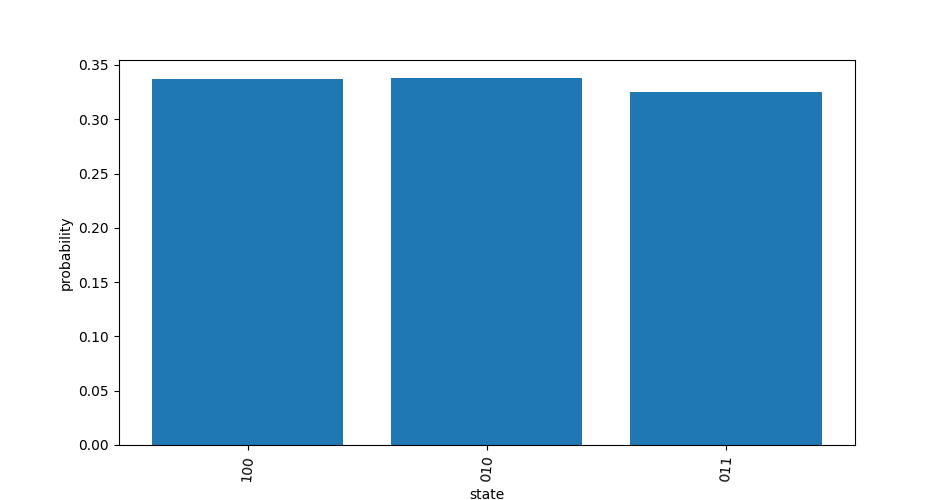

In [18]:
plot_hist(qaoa_example1_interesting, 
          qaoa_example1_interesting.angles_hist["d1_final"], params = params3)

### Interesting cost function with penalty hamiltonian

In [19]:
alpha = -10.0

H_cost_penalty = np.array([5.0, 2.0, 2.0, 2.5, 2.0, 1.0, 3.0, 0.1])
# create penalty hamiltonian
all_states = ["".join(i) for i in list(itertools.product("01", repeat = 3))]
g = get_g(feasible_states)

for state in all_states:
    if state not in feasible_states:
        expr = g[1]
        for i, symbol in enumerate(g[0]):
            expr = expr.subs(symbol, int(state[i]))
        H_cost_penalty[int(state, 2)] += alpha * expr

H_cost_penalty_sympy = Symbol("c") * matrix_to_sympy(np.diag(H_cost_penalty))
display(H_cost_penalty)
display(H_cost_penalty_sympy)

dim= 3.0


array([-15. , -38. ,   2. ,   2.5,   2. , -59. , -17. , -39.9])

c*(-20.3*1x1x1 + 13.3*1x1xsigma3 - 7.2*1xsigma3x1 + 7.7*1xsigma3xsigma3 + 8.175*sigma3x1x1 - 7.675*sigma3x1xsigma3 - 7.175*sigma3xsigma3x1 - 1.825*sigma3xsigma3xsigma3)

In [20]:
penalty_cost_circuit_array = Circuit_maker(H_cost_penalty_sympy)

params4 = {"cost_circuit_array" : penalty_cost_circuit_array,
           "H_cost" : H_cost_penalty}

In [21]:
class QAOA_example1_penalty_hamiltonian(QAOABase):
    def cost(self, string, params):
        H_cost = params.get("H_cost")
        return H_cost[int(string, 2)]

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(3)
        c = ClassicalRegister(3)
        circ = QuantumCircuit(q, c)
        
        cost_circuit_array = params.get("cost_circuit_array")
        
        # initial state
        circ.h(q)
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            circ.rx(-2. * beta, [q[0], q[1], q[2]])
            
        circ.measure(q, c)
        return circ

display(QAOA_example1_penalty_hamiltonian().createCircuit(
    [1.0, 1.0], 1, params = params4).draw())

┌───┐┌────────────┐                                                  »
q23959_0: ┤ H ├┤ Rz(-16.35) ├─────────────────────────■────────────────────────»
          ├───┤└────────────┘                       ┌─┴─┐                      »
q23959_1: ┤ H ├────────────────■─────────────────■──┤ X ├──■────────────────■──»
          ├───┤┌───────────┐ ┌─┴─┐┌───────────┐┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐»
q23959_2: ┤ H ├┤ Rz(-26.6) ├─┤ X ├┤ Rz(-15.4) ├┤ X ├─────┤ X ├┤ Rz(3.65) ├┤ X ├»
          └───┘└───────────┘ └───┘└───────────┘└───┘     └───┘└──────────┘└───┘»
 c1260: 3/═════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                   ┌────────┐ »
«q23959_0: ──■────■─────────────────■──────■────────────────────■───┤ Rx(-2) ├─»
«          ┌─┴─┐  │                 │    ┌─┴─┐   ┌───────────┐┌─┴─┐┌┴────────┴┐»
«q23959_1: ┤ X ├──┼─────────────────┼────┤ X ├───┤ Rz(14.35) ├┤ X ├┤ Rz(14.4) ├»
«          └───┘┌─┴─┐┌───────────┐┌─┴─┐┌─┴───┴──┐└────┬─┬────┘└───┘└──────────┘»
«q23959_2: ─────┤ X ├┤ Rz(15.35) ├┤ X ├┤ Rx(-2) ├─────┤M├──────────────────────»
«               └───┘└───────────┘└───┘└────────┘     └╥┘                      »
« c1260: 3/════════════════════════════════════════════╩═══════════════════════»
«                                                      2                       »
«                    ┌─┐   
«q23959_0: ──────────┤M├───
«          ┌────────┐└╥┘┌─┐
«q23959_1: ┤ Rx(-2) ├─╫─┤M├
«          └────────┘ ║ └╥┘
«q23959_2: ───────────╫──╫─
«                     ║  ║ 
« c1260: 3/═══════════╩══╩═
«                     0  1

In [22]:
qaoa_example1_penalty_hamiltonian = QAOA_example1_penalty_hamiltonian()
qaoa_example1_penalty_hamiltonian.increase_depth(backend = qasmSim, precision = 0.25, params = params4)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= 3.6446161515453634


<IPython.core.display.Javascript object>


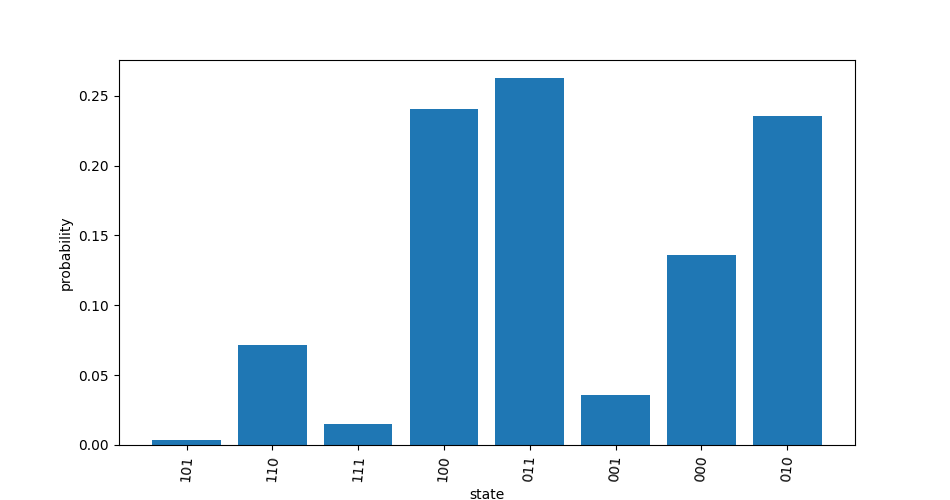

In [23]:
plot_hist(qaoa_example1_penalty_hamiltonian, 
          qaoa_example1_penalty_hamiltonian.angles_hist["d1_final"], params = params4)

## Example 2

### test if mixer works

Feasible subspace: $ B = \{\ket{10010}, \ket{01110}, \ket{10011}, \ket{11101}, \ket{00110}, \ket{01010}\} $

In [24]:
feasible_states2 = np.array(["10010", "01110", "10011", "11101", "00110", "01010"])

# create H_cost
H_cost2 = 20. * np.ones(2 ** 5)
for feasible_state in feasible_states2:
    H_cost2[int(feasible_state, 2)] = 1.
H_cost2_sympy = Symbol("c") * matrix_to_sympy(np.diag(H_cost2))
display(H_cost2_sympy)

dim= 5.0


c*(526.0*1x1x1x1x1 - 38.0*1x1x1x1xsigma3 + 76.0*1x1x1xsigma3x1 + 76.0*1x1x1xsigma3xsigma3 + 38.0*1x1xsigma3xsigma3x1 - 38.0*1x1xsigma3xsigma3xsigma3 + 38.0*1xsigma3x1xsigma3x1 - 38.0*1xsigma3x1xsigma3xsigma3 - 38.0*1xsigma3xsigma3x1x1 + 38.0*1xsigma3xsigma3x1xsigma3 - 76.0*sigma3x1x1x1xsigma3 + 38.0*sigma3x1x1xsigma3x1 + 38.0*sigma3x1x1xsigma3xsigma3 + 38.0*sigma3x1xsigma3x1x1 + 38.0*sigma3x1xsigma3x1xsigma3 - 76.0*sigma3x1xsigma3xsigma3x1 + 38.0*sigma3xsigma3x1x1x1 + 38.0*sigma3xsigma3x1x1xsigma3 - 76.0*sigma3xsigma3x1xsigma3x1 + 76.0*sigma3xsigma3xsigma3x1x1 - 38.0*sigma3xsigma3xsigma3xsigma3x1 - 38.0*sigma3xsigma3xsigma3xsigma3xsigma3)

In [25]:
# create H_mixer
table2 = {
    (1, 2) : ["01100", "10000"],
    (1, 3) : ["00010", "00011"],
    (1, 4) : ["00010", "01101"],
    (1, 5) : ["00100", "10000"],
    (1, 6) : ["01000", "10000"],
    (2, 3) : ["01100", "10001"],
    (2, 4) : ["00010", "10001"],
    (2, 5) : ["00100", "01100"],
    (2, 6) : ["01000", "01100"],
    (3, 4) : ["00011", "01101"],
    (3, 5) : ["00100", "10001"],
    (3, 6) : ["01000", "10001"],
    (4, 5) : ["00010", "11001"],
    (4, 6) : ["00010", "10101"],
    (5, 6) : ["00100", "01000"]}

H_mixer2 = 0
T_c2 = get_T(2, "nearest_int")
for index, (key, mix_states) in enumerate(table2.items()):
    T_ij = get_T(len(feasible_states2), "leftright", i = key[0] - 1, j = key[1] - 1)
    H_b_ij = get_Pauli_string_with_algorithm3(feasible_states2, T_ij)
    H_c_ij = get_Pauli_string_with_algorithm3(mix_states, T_c2)
    a = Symbol(f"a{index}")
    H_mixer2 += a * simplifyH(H_b_ij + H_c_ij)

display(H_mixer2)

a0*(0.125*sigma1xsigma1xsigma1x1x1 + 0.125*sigma1xsigma1xsigma1x1xsigma3 - 0.125*sigma1xsigma2xsigma2x1x1 - 0.125*sigma1xsigma2xsigma2x1xsigma3 + 0.125*sigma2xsigma1xsigma2x1x1 + 0.125*sigma2xsigma1xsigma2x1xsigma3 + 0.125*sigma2xsigma2xsigma1x1x1 + 0.125*sigma2xsigma2xsigma1x1xsigma3) + a1*(0.125*1x1x1x1xsigma1 - 0.125*1x1x1xsigma3xsigma1 + 0.125*1x1xsigma3x1xsigma1 - 0.125*1x1xsigma3xsigma3xsigma1 + 0.125*1xsigma3x1x1xsigma1 - 0.125*1xsigma3x1xsigma3xsigma1 + 0.125*1xsigma3xsigma3x1xsigma1 - 0.125*1xsigma3xsigma3xsigma3xsigma1) + a10*(0.125*sigma1x1xsigma1x1xsigma1 + 0.125*sigma1x1xsigma2x1xsigma2 + 0.125*sigma1xsigma3xsigma1x1xsigma1 + 0.125*sigma1xsigma3xsigma2x1xsigma2 - 0.125*sigma2x1xsigma1x1xsigma2 + 0.125*sigma2x1xsigma2x1xsigma1 - 0.125*sigma2xsigma3xsigma1x1xsigma2 + 0.125*sigma2xsigma3xsigma2x1xsigma1) + a11*(0.125*sigma1xsigma1x1x1xsigma1 + 0.125*sigma1xsigma1xsigma3x1xsigma1 + 0.125*sigma1xsigma2x1x1xsigma2 + 0.125*sigma1xsigma2xsigma3x1xsigma2 - 0.125*sigma2xsigma1x1x1xs

In [26]:
H_mixer2_array = Circuit_maker(H_mixer2)
H_cost2_array = Circuit_maker(H_cost2_sympy)

params2 = {"mixer_circuit_array" : H_mixer2_array,
           "cost_circuit_array" : H_cost2_array,
           "H_cost" : H_cost2,
           "feasible_states" : feasible_states2}

In [27]:
class QAOA_example2(QAOABase):
    def cost(self, string, params):
        costs = params.get("H_cost")
        return costs[int(string, 2)]

    def createCircuit(self, angles, depth, params={}):  
        q = QuantumRegister(5)
        c = ClassicalRegister(5)
        circ = QuantumCircuit(q, c)
        
        B = params.get("feasible_states")
        cost_circuit_array = params.get("cost_circuit_array")
        mixer_circuit_array = params.get("mixer_circuit_array")
        
        # initial state
        ampl_vec = np.zeros(32)
        ampl = 1 / np.sqrt(len(B))
        for state in B:
            ampl_vec[int(state, 2)] = ampl 
        circ.initialize(ampl_vec, q[::-1])
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            mixer_circuit_array.add_gates(circ, beta)
            
            
        circ.measure(q, c)
        return circ

display(QAOA_example2().createCircuit(
    [1.0, 1.0], 1, params = params2).draw())

»
q33273_0: »
          »
q33273_1: »
          »
q33273_2: »
          »
q33273_3: »
          »
q33273_4: »
          »
 c1691: 5/»
          »
«          ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q33273_0: ┤4                                                                                                                 ├»
«          │                                                                                                                  │»
«q33273_1: ┤3                                                                                                                 ├»
«          │                                                                                                                  │»
«q33273_2: ┤2 Initialize(0,0,0,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0.40825,0,0,0,0,0,0,0,0,0,0.40825,0,0) ├»
«          │                                                                                                                  │»
«q33273_3: ┤1                                                                                                                 ├»
«          │                                                                                                                  │»
«q33273_4: ┤0                                                                                                                 ├»
«          └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
« c1691: 5/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                              »
«                                                                              »
«q33273_0: ─────────────────────────────────────────────────■──────────────────»
«                                                           │                  »
«q33273_1: ───────────────────────■───────────────■────■────┼──────────────────»
«                                 │               │  ┌─┴─┐  │                  »
«q33273_2: ──■───────────────■────┼───────────────┼──┤ X ├──┼────■─────────────»
«          ┌─┴─┐┌─────────┐┌─┴─┐┌─┴─┐┌─────────┐┌─┴─┐└───┘┌─┴─┐  │  ┌─────────┐»
«q33273_3: ┤ X ├┤ Rz(-76) ├┤ X ├┤ X ├┤ Rz(-76) ├┤ X ├─────┤ X ├──┼──┤ Rz(-76) ├»
«          └───┘└─────────┘└───┘└───┘└─────────┘└───┘     └───┘┌─┴─┐├─────────┤»
«q33273_4: ────────────────────────────────────────────────────┤ X ├┤ Rz(-76) ├»
«                                                              └───┘└─────────┘»
« c1691: 5/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                          »
«q33273_0: ──■─────────■─────────────────────────■───────■─────────────────»
«            │         │                         │       │                 »
«q33273_1: ──┼─────────┼────■────────────────────┼───────┼─────────────────»
«            │         │  ┌─┴─┐                  │     ┌─┴─┐    ┌─────────┐»
«q33273_2: ──┼────■────┼──┤ X ├──────────────────┼─────┤ X ├────┤ Rz(-76) ├»
«          ┌─┴─┐  │  ┌─┴─┐└───┘                ┌─┴─┐┌──┴───┴───┐└─────────┘»
«q33273_3: ┤ X ├──┼──┤ X ├──■───────────────■──┤ X ├┤ Rz(-152) ├───────────»
«          └───┘┌─┴─┐└───┘┌─┴─┐┌─────────┐┌─┴─┐└───┘└──────────┘           »
«q33273_4: ─────┤ X ├─────┤ X ├┤ Rz(-76) ├┤ X ├────────────────────────────»
«               └───┘     └───┘└─────────┘└───┘                            »
« c1691: 5/════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                             »
«q33273_0: ──■────■────────────────────────

In [28]:
start = time.time()
qaoa_example2 = QAOA_example2()
qaoa_example2.increase_depth(backend = qasmSim, precision = 5.0, params = params2)
print(f"time:{time.time() - start}")

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -1.0
time:821.3067119121552


<IPython.core.display.Javascript object>


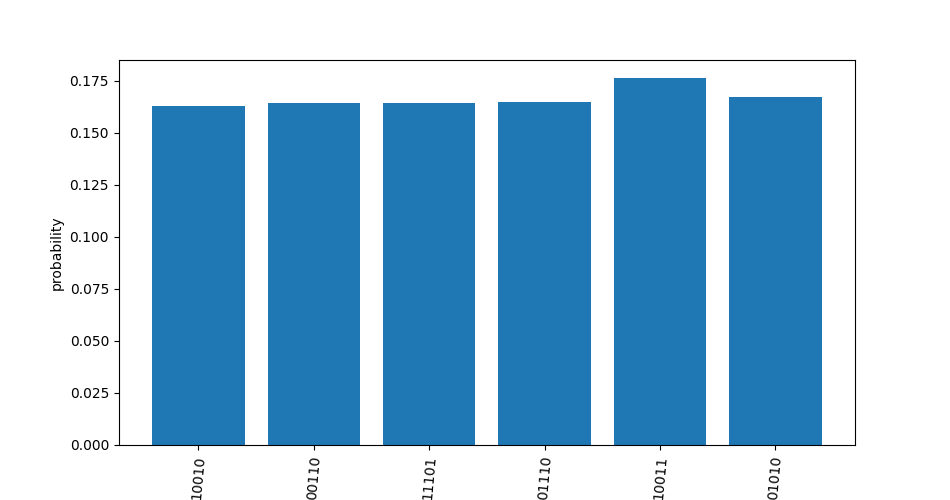

In [29]:
plot_hist(qaoa_example2, qaoa_example2.angles_hist["d1_final"], params = params2)

### interesting cost function with algorithms

In [30]:
H_cost_interesting2 = 4.0 * np.ones(2 ** len(feasible_states2[0]))
for i, state in enumerate(feasible_states2):
    H_cost_interesting2[int(state, 2)] = i    
random_indices = [0, 1, 20, 30, 15, 17]
for i in random_indices:
    H_cost_interesting2[i] = 20.0
    
H_cost_interesting2_sympy = Symbol("c") * matrix_to_sympy(np.diag(H_cost_interesting2))

display(H_cost_interesting2)
display(H_cost_interesting2_sympy)

dim= 5.0


array([20., 20.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,
        4.,  1., 20.,  4., 20.,  0.,  2., 20.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  3., 20.,  4.])

c*(215.0*1x1x1x1x1 - 3.0*1x1x1x1xsigma3 + 39.0*1x1x1xsigma3x1 + 5.0*1x1x1xsigma3xsigma3 - 1.0*1x1xsigma3x1x1 - 31.0*1x1xsigma3x1xsigma3 + 67.0*1x1xsigma3xsigma3x1 - 35.0*1x1xsigma3xsigma3xsigma3 + 29.0*1xsigma3x1x1x1 - 1.0*1xsigma3x1x1xsigma3 + 101.0*1xsigma3x1xsigma3x1 - 1.0*1xsigma3x1xsigma3xsigma3 + 53.0*1xsigma3xsigma3x1x1 - 37.0*1xsigma3xsigma3x1xsigma3 + 9.0*1xsigma3xsigma3xsigma3x1 - 25.0*1xsigma3xsigma3xsigma3xsigma3 + 5.0*sigma3x1x1x1x1 - 33.0*sigma3x1x1x1xsigma3 - 3.0*sigma3x1x1xsigma3x1 + 31.0*sigma3x1x1xsigma3xsigma3 + 41.0*sigma3x1xsigma3x1x1 + 71.0*sigma3x1xsigma3x1xsigma3 + 21.0*sigma3x1xsigma3xsigma3x1 - 5.0*sigma3x1xsigma3xsigma3xsigma3 + 7.0*sigma3xsigma3x1x1x1 + 37.0*sigma3xsigma3x1x1xsigma3 - 9.0*sigma3xsigma3x1xsigma3x1 - 35.0*sigma3xsigma3x1xsigma3xsigma3 + 35.0*sigma3xsigma3xsigma3x1x1 - 3.0*sigma3xsigma3xsigma3x1xsigma3 + 31.0*sigma3xsigma3xsigma3xsigma3x1 + 65.0*sigma3xsigma3xsigma3xsigma3xsigma3)

In [31]:
H_cost2_interesting_array = Circuit_maker(H_cost_interesting2_sympy)

params2_2 = {"cost_circuit_array" : H_cost2_interesting_array,
           "mixer_circuit_array" : H_cost2_array,
           "H_cost" : H_cost_interesting2,
            "feasible_states" : feasible_states2}

In [32]:
class QAOA_example2_interesting(QAOABase):
    def cost(self, string, params):
        costs = params.get("H_cost")
        return costs[int(string, 2)]

    def createCircuit(self, angles, depth, params={}):  
        q = QuantumRegister(5)
        c = ClassicalRegister(5)
        circ = QuantumCircuit(q, c)
        
        B = params.get("feasible_states")
        cost_circuit_array = params.get("cost_circuit_array")
        mixer_circuit_array = params.get("mixer_circuit_array")
        
        # initial state
        ampl_vec = np.zeros(32)
        ampl = 1 / np.sqrt(len(B))
        for state in B:
            ampl_vec[int(state, 2)] = ampl 
        circ.initialize(ampl_vec, q[::-1])
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            mixer_circuit_array.add_gates(circ, beta)
            
        circ.measure(q, c)
        return circ

display(QAOA_example2_interesting().createCircuit(
    [1.0, 1.0], 1, params = params2_2).draw())

»
q48836_0: »
          »
q48836_1: »
          »
q48836_2: »
          »
q48836_3: »
          »
q48836_4: »
          »
 c2106: 5/»
          »
«          ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q48836_0: ┤4                                                                                                                 ├»
«          │                                                                                                                  │»
«q48836_1: ┤3                                                                                                                 ├»
«          │                                                                                                                  │»
«q48836_2: ┤2 Initialize(0,0,0,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0,0,0,0.40825,0.40825,0,0,0,0,0,0,0,0,0,0.40825,0,0) ├»
«          │                                                                                                                  │»
«q48836_3: ┤1                                                                                                                 ├»
«          │                                                                                                                  │»
«q48836_4: ┤0                                                                                                                 ├»
«          └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
« c2106: 5/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                              »
«          ┌─────────┐                                                     »
«q48836_0: ┤ Rz(-10) ├─────■──────────────────■────────────────────────────»
«          └─────────┘   ┌─┴─┐   ┌─────────┐┌─┴─┐                          »
«q48836_1: ──────────────┤ X ├───┤ Rz(-14) ├┤ X ├──■───────────────────────»
«                        └───┘   └─────────┘└───┘┌─┴─┐                     »
«q48836_2: ──────────────────────────────────────┤ X ├──■───────────────■──»
«                                                └───┘┌─┴─┐┌─────────┐┌─┴─┐»
«q48836_3: ─────■─────────────────────■───────────────┤ X ├┤ Rz(-18) ├┤ X ├»
«             ┌─┴─┐   ┌─────────┐   ┌─┴─┐             └───┘└─────────┘└───┘»
«q48836_4: ───┤ X ├───┤ Rz(-10) ├───┤ X ├──────────────────────────────────»
«             └───┘   └─────────┘   └───┘                                  »
« c2106: 5/════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                              »
«q48836_0: ───────■───────────────────────────────■────■───────────────────────»
«                 │  ┌─────────┐                  │    │                       »
«q48836_1: ──■────┼──┤ Rz(-58) ├──────────────────┼────┼───────────────────────»
«          ┌─┴─┐┌─┴─┐└─────────┘                ┌─┴─┐  │                       »
«q48836_2: ┤ X ├┤ X ├─────■──────────────────■──┤ X ├──┼───────────────────────»
«          └───┘└───┘   ┌─┴─┐   ┌─────────┐┌─┴─┐└───┘┌─┴─┐                     »
«q48836_3: ─────────────┤ X ├───┤ Rz(-42) ├┤ X ├─────┤ X ├──■───────────────■──»
«                       └───┘   └─────────┘└───┘     └───┘┌─┴─┐┌─────────┐┌─┴─┐»
«q48836_4: ───────────────────────────────────────────────┤ X ├┤ Rz(-62) ├┤ X ├»
«                                                         └───┘└─────────┘└───┘»
« c2106: 5/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                        »
«q48836_0: ──■────■─────────────────────────────

In [33]:
qaoa_example2_interesting = QAOA_example2_interesting()
qaoa_example2_interesting.increase_depth(backend = qasmSim, precision = 0.25, params = params2_2)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= -2.5283203125


<IPython.core.display.Javascript object>


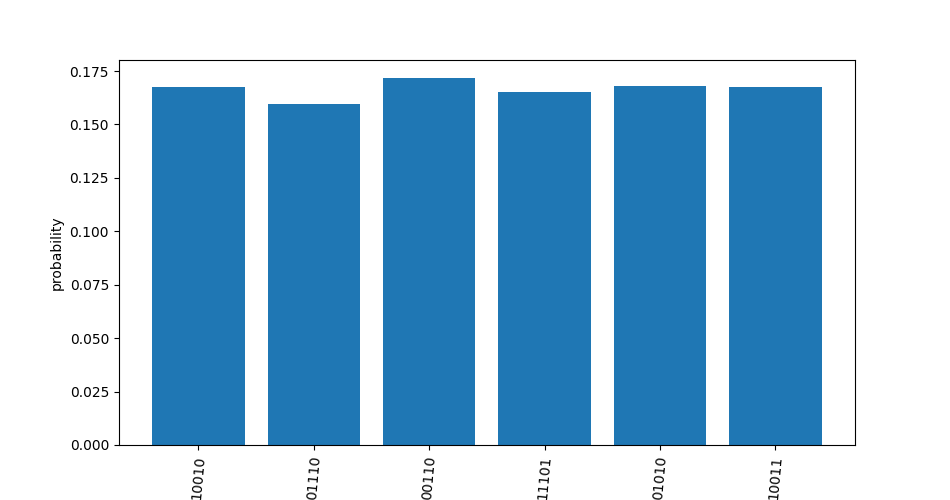

In [34]:
plot_hist(qaoa_example2_interesting, 
          qaoa_example2_interesting.angles_hist["d1_final"], params = params2_2)

### interesting cost function with penalty hamiltonian

In [35]:
alpha = -10.0

H_cost_penalty2 = np.copy(H_cost_interesting2)
# create penalty hamiltonian
all_states = ["".join(i) for i in list(itertools.product("01", repeat = 5))]
g = get_g(feasible_states2)

for state in all_states:
    if state not in feasible_states2:
        expr = g[1]
        for i, symbol in enumerate(g[0]):
            expr = expr.subs(symbol, int(state[i]))
        H_cost_penalty2[int(state, 2)] += alpha * expr

print(H_cost_penalty2)
H_cost_penalty2_sympy = Symbol("c") * matrix_to_sympy(np.diag(H_cost_penalty2))
display(H_cost_penalty2_sympy)

[-2.860e+03 -6.460e+03 -1.960e+02 -9.560e+02 -2.156e+03 -5.756e+03
  4.000e+00 -1.076e+03 -2.156e+03 -5.756e+03  5.000e+00 -1.076e+03
 -1.596e+03 -3.596e+03  1.000e+00 -9.400e+02 -2.156e+03 -3.180e+03
  0.000e+00  2.000e+00 -2.860e+03 -3.596e+03 -3.560e+02 -9.560e+02
 -2.876e+03 -3.596e+03 -3.560e+02 -9.560e+02 -2.156e+03  3.000e+00
 -4.600e+02 -1.076e+03]
dim= 5.0


c*(-59145.0*1x1x1x1x1 + 18797.0*1x1x1x1xsigma3 - 42361.0*1x1x1xsigma3x1 + 7445.0*1x1x1xsigma3xsigma3 - 6001.0*1x1xsigma3x1x1 + 3969.0*1x1xsigma3x1xsigma3 - 8653.0*1x1xsigma3xsigma3x1 + 5565.0*1x1xsigma3xsigma3xsigma3 - 5971.0*1xsigma3x1x1x1 + 3999.0*1xsigma3x1x1xsigma3 - 8619.0*1xsigma3x1xsigma3x1 + 5599.0*1xsigma3x1xsigma3xsigma3 + 7893.0*1xsigma3xsigma3x1x1 - 5237.0*1xsigma3xsigma3x1xsigma3 + 5609.0*1xsigma3xsigma3xsigma3x1 - 3145.0*1xsigma3xsigma3xsigma3xsigma3 - 9995.0*sigma3x1x1x1x1 + 14527.0*sigma3x1x1x1xsigma3 - 9843.0*sigma3x1x1xsigma3x1 + 10431.0*sigma3x1x1xsigma3xsigma3 - 2679.0*sigma3x1xsigma3x1x1 - 1129.0*sigma3x1xsigma3x1xsigma3 + 821.0*sigma3x1xsigma3xsigma3x1 - 2005.0*sigma3x1xsigma3xsigma3xsigma3 - 2713.0*sigma3xsigma3x1x1x1 - 1163.0*sigma3xsigma3x1x1xsigma3 + 791.0*sigma3xsigma3x1xsigma3x1 - 2035.0*sigma3xsigma3x1xsigma3xsigma3 - 5165.0*sigma3xsigma3xsigma3x1x1 + 1117.0*sigma3xsigma3xsigma3x1xsigma3 - 3089.0*sigma3xsigma3xsigma3xsigma3x1 + 865.0*sigma3xsigma3xsigma3xsi

In [36]:
H_cost_penalty2_array = Circuit_maker(H_cost_penalty2_sympy)

params2_3 = {"cost_circuit_array" : H_cost_penalty2_array,
             "H_cost" : H_cost_penalty2}

In [37]:
class QAOA_example2_penalty_hamiltonian(QAOABase):
    def cost(self, string, params):
        H_cost = params.get("H_cost")
        return H_cost[int(string, 2)]

    def createCircuit(self, angles, depth, params={}):
        q = QuantumRegister(5)
        c = ClassicalRegister(5)
        circ = QuantumCircuit(q, c)
        cost_circuit_array = params.get("cost_circuit_array")
        
        # initial state
        circ.h(q)
        
        for d in range(depth):
            gamma = angles[2 * d]
            beta = angles[2 * d + 1]
            
            # H_cost
            cost_circuit_array.add_gates(circ, gamma)
            
            # H_mixer
            circ.rx(-2. * beta, [q[0], q[1], q[2], q[3], q[4]])
            
        circ.measure(q, c)
        return circ

display(QAOA_example2_penalty_hamiltonian().createCircuit(
    [1.0, 1.0], 1, params = params2_3).draw())

┌───┐                                                             »
q59153_0: ┤ H ├──■───────────────────────────■────■─────────────────────────»
          ├───┤┌─┴─┐                       ┌─┴─┐  │                         »
q59153_1: ┤ H ├┤ X ├──■─────────────────■──┤ X ├──┼─────────────────────────»
          ├───┤└───┘  │                 │  └───┘┌─┴─┐                       »
q59153_2: ┤ H ├───────┼─────────────────┼───────┤ X ├──■─────────────────■──»
          ├───┤     ┌─┴─┐┌───────────┐┌─┴─┐     └───┘┌─┴─┐┌───────────┐┌─┴─┐»
q59153_3: ┤ H ├─────┤ X ├┤ Rz(-1582) ├┤ X ├──────────┤ X ├┤ Rz(-1642) ├┤ X ├»
          ├───┤     └───┘└───────────┘└───┘          └───┘└───────────┘└───┘»
q59153_4: ┤ H ├─────────────────────────────────────────────────────────────»
          └───┘                                                             »
 c2535: 5/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«q59153_0: ──■────■───────────────────────────────────────────────■────■───────»
«            │  ┌─┴─┐                                           ┌─┴─┐┌─┴─┐     »
«q59153_1: ──┼──┤ X ├──■─────────────────────────────────────■──┤ X ├┤ X ├──■──»
«          ┌─┴─┐└───┘┌─┴─┐                                 ┌─┴─┐└───┘└───┘┌─┴─┐»
«q59153_2: ┤ X ├─────┤ X ├──■───────────────────────────■──┤ X ├──────────┤ X ├»
«          └───┘     └───┘┌─┴─┐                       ┌─┴─┐└───┘          └───┘»
«q59153_3: ───────────────┤ X ├──■─────────────────■──┤ X ├────────────────────»
«                         └───┘┌─┴─┐┌───────────┐┌─┴─┐└───┘                    »
«q59153_4: ────────────────────┤ X ├┤ Rz(-1730) ├┤ X ├─────────────────────────»
«                              └───┘└───────────┘└───┘                         »
« c2535: 5/════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                                  »
«q59153_0: ──────────────────────────────■─────────────────────────»
«                                      ┌─┴─┐                       »
«q59153_1: ─────────────────────────■──┤ X ├────────────────────■──»
«                                 ┌─┴─┐└───┘                    │  »
«q59153_2: ──■─────────────────■──┤ X ├──■─────────────────■────┼──»
«            │                 │  └───┘  │                 │    │  »
«q59153_3: ──┼─────────────────┼─────────┼─────────────────┼────┼──»
«          ┌─┴─┐┌───────────┐┌─┴─┐     ┌─┴─┐┌───────────┐┌─┴─┐┌─┴─┐»
«q59153_4: ┤ X ├┤ Rz(-2234) ├┤ X ├─────┤ X ├┤ Rz(-7938) ├┤ X ├┤ X ├»
«          └───┘└───────────┘└───┘     └───┘└───────────┘└───┘└───┘»
« c2535: 5/════════════════════════════════════════════════════════»
«                                                                  »
«                                                                   »
«q59153_0: ─────────────────────────────────────────────────────────»
«                                                                   »
«q59153_1: ───────────────■─────────────────────────────────■───────»
«                         │                                 │       »
«q59153_2: ──────■────────┼────────────────────────────■────┼───────»
«              ┌─┴─┐      │                          ┌─┴─┐┌─┴─┐     »
«q59153_3: ────┤ X ├──────┼────■──────────────────■──┤ X ├┤ X ├──■──»
«          ┌───┴───┴───┐┌─┴─┐┌─┴─┐┌────────────┐┌─┴─┐└───┘└───┘┌─┴─┐»
«q59153_4: ┤ Rz(-7998) ├┤ X ├┤ X ├┤ Rz(-11130) ├┤ X ├──────────┤ X ├»
«          └───────────┘└───┘└───┘└────────────┘└───┘          └───┘»
« c2535: 5/═════════════════════════════════════════════════════════»
«                                                                   »
«                                                                    »
«q59153_0: ──────────────────────────────────────────────────────

In [38]:
qaoa_example2_penalty_hamiltonian = QAOA_example2_penalty_hamiltonian()
qaoa_example2_penalty_hamiltonian.increase_depth(backend = qasmSim, precision = 0.25, params = params2_3)

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done
cost(depth= 1 )= 1332.6845041725853


<IPython.core.display.Javascript object>


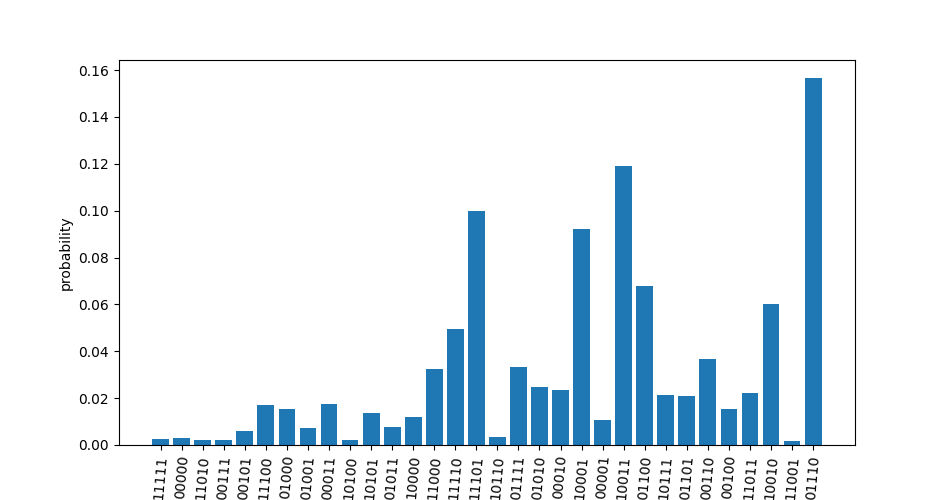

In [41]:
plot_hist(qaoa_example2_penalty_hamiltonian, 
          qaoa_example2_penalty_hamiltonian.angles_hist["d1_final"], params = params2_3)

In [40]:
plt.imshow(qaoa_example2_penalty_hamiltonian.E)
plt.show()